In [247]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb

from bayes_opt import BayesianOptimization

In [96]:

dato = pd.read_csv('./Datos/prediccion/LaLiga_Matches_1995-2021.csv')

In [3]:
dato.shape

(10044, 10)

In [50]:
dato.head()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,categorical FTR,categorical Home,categorical Away,weekday
0,1995-96,1995-09-02,La Coruna,Valencia,3,0,H,2.0,0.0,H,2,21,41,5
1,1995-96,1995-09-02,Sp Gijon,Albacete,3,0,H,3.0,0.0,H,2,39,1,5
2,1995-96,1995-09-03,Ath Bilbao,Santander,4,0,H,2.0,0.0,H,2,3,36,6
3,1995-96,1995-09-03,Ath Madrid,Sociedad,4,1,H,1.0,1.0,D,2,4,38,6
4,1995-96,1995-09-03,Celta,Compostela,0,1,A,0.0,0.0,D,0,8,9,6


In [5]:
dato.isnull().sum()

Season      0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        2
HTAG        2
HTR         2
dtype: int64

In [124]:
#create a dictionary of football team
team_name = {}
index = 0
for idx, row in dato.iterrows():
    name = row['HomeTeam']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
    name = row['AwayTeam']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
        
team_name

{'La Coruna': 0,
 'Valencia': 1,
 'Sp Gijon': 2,
 'Albacete': 3,
 'Ath Bilbao': 4,
 'Santander': 5,
 'Ath Madrid': 6,
 'Sociedad': 7,
 'Celta': 8,
 'Compostela': 9,
 'Espanol': 10,
 'Salamanca': 11,
 'Merida': 12,
 'Betis': 13,
 'Sevilla': 14,
 'Tenerife': 15,
 'Valladolid': 16,
 'Barcelona': 17,
 'Vallecano': 18,
 'Real Madrid': 19,
 'Zaragoza': 20,
 'Oviedo': 21,
 'Hercules': 22,
 'Extremadura': 23,
 'Logrones': 24,
 'Mallorca': 25,
 'Alaves': 26,
 'Villareal': 27,
 'Malaga': 28,
 'Numancia': 29,
 'Las Palmas': 30,
 'Osasuna': 31,
 'Villarreal': 32,
 'Recreativo': 33,
 'Murcia': 34,
 'Levante': 35,
 'Getafe': 36,
 'Cadiz': 37,
 'Gimnastic': 38,
 'Almeria': 39,
 'Xerez': 40,
 'Granada': 41,
 'Elche': 42,
 'Eibar': 43,
 'Cordoba': 44,
 'Leganes': 45,
 'Girona': 46,
 'Huesca': 47}

In [9]:
n_matches = dato.shape[0]

# Calculate number of features. -1 because we are saving one as the target variable (win/lose/draw)
n_features = dato.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(dato[dato.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 10044
Number of features: 9
Number of matches won by home team: 4772
Win rate of home team: 47.51%


In [186]:
lb_make_outs = LabelEncoder() # se le asigna un entero
dato['categorical FTR'] = lb_make_outs.fit_transform(dato['FTR'])
lb_make_teams = LabelEncoder()
dato['categorical Home'] = dato.HomeTeam.apply(lambda x: team_name[x])
dato['categorical Away'] = dato.AwayTeam.apply(lambda x: team_name[x])

In [189]:
lb_make_outs.transform(['A'])

array([0])

In [126]:
dato.Date = pd.to_datetime(dato.Date, dayfirst=True)
dato['weekday'] = dato.Date.dt.weekday #se puede acceder a la fecha

In [127]:
dato['weekday_sin'] = np.sin(dato['weekday']*(2.*np.pi/7))
dato['weekday_cos'] = np.cos(dato['weekday']*(2.*np.pi/7))

In [100]:
dato.weekday_cos

0       -0.222521
1       -0.222521
2        0.623490
3        0.623490
4        0.623490
           ...   
10039   -0.222521
10040   -0.222521
10041   -0.222521
10042    0.623490
10043    0.623490
Name: weekday_cos, Length: 10044, dtype: float64

In [48]:
dato['categorical FTR'].value_counts()

2    4772
0    2711
1    2561
Name: categorical FTR, dtype: int64

In [93]:
#dato = pd.get_dummies(dato, columns=['FTR'])
dato.head()

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,categorical FTR,categorical Home,categorical Away,weekday,weekday_sin,weekday_cos
0,1995-96,1995-09-02,La Coruna,Valencia,3,0,H,2.0,0.0,H,2,21,41,5,-0.974928,-0.222521
1,1995-96,1995-09-02,Sp Gijon,Albacete,3,0,H,3.0,0.0,H,2,39,1,5,-0.974928,-0.222521
2,1995-96,1995-09-03,Ath Bilbao,Santander,4,0,H,2.0,0.0,H,2,3,36,6,-0.781831,0.623490
3,1995-96,1995-09-03,Ath Madrid,Sociedad,4,1,H,1.0,1.0,D,2,4,38,6,-0.781831,0.623490
4,1995-96,1995-09-03,Celta,Compostela,0,1,A,0.0,0.0,D,0,8,9,6,-0.781831,0.623490


In [206]:
# Separate into feature set and target variable
columns_name=['weekday_sin','weekday_cos','categorical Home','categorical Away']
# X_all = dato[columns_name]
X_all = dato
y_all = dato['categorical FTR']

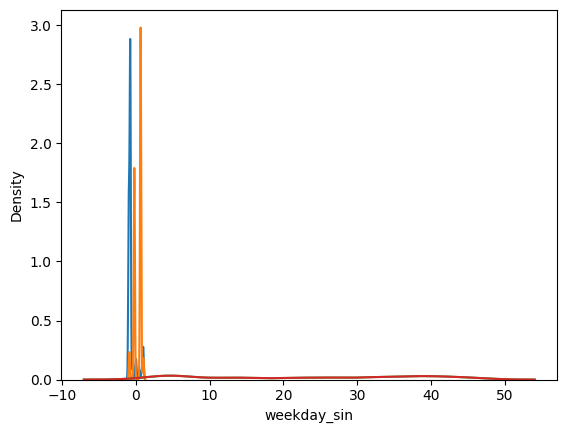

In [56]:
for col in X_all:
    sns.kdeplot(X_all[col])

In [215]:
#Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=0.2, random_state=53)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (8035, 19) (8035,)
Test set: (2009, 19) (2009,)


In [217]:
model = xgb.XGBClassifier(n_estimators=4, max_depth=4)
model.fit(X_train[columns_name],y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=4, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [231]:
y_pred = model.predict(X_test[columns_name])
accuracy = np.mean(y_pred == y_test)#array de numpy 0-1
accuracy

0.5067197610751618

In [245]:
# aggdf = X_test.groupby(['FTR']).agg({
#     'pred_ok': 'sum'
# }).reset_index()

# aggdf
X_test[
    (X_test.pred_ok) &
    (X_test.FTR == 'D')
]

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,categorical Home,categorical Away,weekday,weekday_sin,weekday_cos,draw,homewon,awaywon,pred,pred_ok
9738,2020-21,2020-11-07,Huesca,Eibar,1,1,D,0.0,1.0,A,...,47,43,5,-0.974928,-0.222521,True,False,False,1,True
5956,2010-11,2010-11-07,Almeria,Sp Gijon,1,1,D,1.0,0.0,H,...,39,2,6,-0.781831,0.623490,True,False,False,1,True


In [212]:
def predict(dataframe, modelo=model):
  df = dataframe.copy()
  df.Date = pd.to_datetime(df.Date, dayfirst=True)
  df['weekday'] = df.Date.dt.weekday #se puede acceder a la fecha
  df['weekday_sin'] = np.sin(df['weekday']*(2.*np.pi/7))
  df['weekday_cos'] = np.cos(df['weekday']*(2.*np.pi/7))
  df['categorical Home'] = df.HomeTeam.apply(lambda x: team_name[x])
  df['categorical Away'] = df.AwayTeam.apply(lambda x: team_name[x])
  cols = ['weekday_sin', 'weekday_cos', 'categorical Home', 'categorical Away']
  predictions = model.predict(df[cols])
  return lb_make_outs.inverse_transform(predictions)

In [246]:
dataframe = pd.DataFrame(
  {
    'HomeTeam': ['Huesca'],
    'AwayTeam': ['Eibar'],
    'Date': ['07/11/2020']
  }
)
predict(dataframe)

array(['D'], dtype=object)

In [156]:
dato.columns

Index(['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'categorical FTR', 'categorical Home',
       'categorical Away', 'weekday', 'weekday_sin', 'weekday_cos'],
      dtype='object')

In [166]:
drawinput = dato[dato.FTR == 'D'][[
    'Date',
    'HomeTeam',
    'AwayTeam'
]]

In [204]:
# HomeTeam, AwayTeam, FTR, pred
dato

,weekday_sin,weekday_cos,categorical Home,categorical Away
7894,-0.974928,-0.222521,13,8
6728,-0.974928,-0.222521,20,0
7342,0.000000,1.000000,28,32
9469,-0.974928,-0.222521,10,17
788,-0.781831,0.623490,16,24
...,...,...,...,...
982,0.974928,-0.222521,15,5
1656,-0.781831,0.623490,13,16
4835,-0.781831,0.623490,39,6
9382,-0.781831,0.623490,31,1


In [198]:
# aggdf = dato.groupby(['HomeTeam', 'AwayTeam']).agg({
#   'draw': 'sum',
#   'homewon': 'sum',
#   'awaywon': 'sum'
# }).reset_index()

# aggdf.sort_values(by='draw', ascending=False)

# aggdf[
#   (aggdf.draw > (aggdf.homewon + aggdf.awaywon))
# ]

lb_make_outs.classes_

array(['A', 'D', 'H'], dtype=object)

In [61]:
model.save_model('./modelo0.json')